# Lab 3: Numerical errors

In this lab we will investigate some of the practical implications of the way numbers are stored in computers. In particular, we will look at problems that can arise for the unwary when using floating-point numbers.

We will check our answers against the "official results" from `sys.float_info` – so before getting any further, let's import this:

In [1]:
from sys import float_info

## Machine precision

**Write a program to find the approximate machine precision** – that is, the largest number $\epsilon$ such that $1 + \epsilon = 1$ within the precision of the calculation.

An appropriate algorithm would be

    Set epsilon to 0.1
    Loop until 1 + epsilon is equal to 1:
        Set epsilon to half its current value

In [3]:
epsilon = 0.1

while epsilon + 1 != 1:
    
    epsilon = (epsilon/2)
print(epsilon)

8.881784197001253e-17


Let's check this against what we know about how numbers are stored in computers. `float_info.mant_dig` will tell you how many bits (i.e., binary digits) are available to store the significand:

In [4]:
float_info.mant_dig

53

Can you use this information to calculate the theoretical epsilon? You shouldn't expect to match exactly with the results of your test program (can you see why?) but you should have the correct order of magnitude.

In [5]:
(2**-52)

2.220446049250313e-16

Check your answer against `float_info.epsilon`. This should match your theoretical value exactly.

In [6]:
float_info.epsilon

2.220446049250313e-16

## Overflow and underflow

**Write a program to find the maximum and minimum positive numbers representable as a Python `float`.**

You can use a very similar algorithm, but this time you will need to test whether the number is equal to $\infty$, which you can represent as `float('inf')`, or zero.

In [2]:
n = 1.0
while n != float('inf'):
    i = n
    n = n*10
print(i)

9.999999999999998e+307


In [3]:
epsilon = 0.1
last_one = 0.1
while 0 + epsilon != 0:
        last_one = epsilon
        epsilon = (epsilon/2)
            

print(last_one)

5e-324


**Check your answers** against the "official" numbers from the following code:

In [19]:
float_info.min, float_info.max

(2.2250738585072014e-308, 1.7976931348623157e+308)

You will notice something odd: while the greatest possible number should match your results fairly well, the smallest possible number from your results should be several orders of magnitude than is theoretically possible! This is because of a clever process known as *gradual underflow*. 

To investigate, **start with a number near the smallest possible, say $10^{-300}$, and divide repeatedly by 300, printing out the result at each step.** What do you notice about the precision of each result? Can you explain what is going on?

In [2]:
x = 10**-300

while x > 0:
    x = x/300
    print(x)

    

3.333333333333333e-303
1.1111111111111111e-305
3.7037037037037035e-308
1.23456790123455e-310
4.11522633745e-313
1.371742115e-315
4.572474e-318
1.524e-320
5e-323
0.0


## Integer overflow

As we noted in class, it's a little tricky to demonstrate integer overflow using the base Python library, because it cleverly increases the amount of memory allocated in order to be able to store arbitrarily large integers. The `array` type from the `numpy` library, however, doesn't do this. (This is on balance a good thing: it is designed to deal fast with very large amounts of data, and being able to specify exactly how much memory should be reserved for each array entry makes sense if there are millions of entries.)

We will create an `array` with only one component, which we specify as an integer occupying sixteen bits of memory:

In [18]:
from numpy import array
my_integer = array([0], dtype='int16')
print(my_integer)

[0]


Remembering that one of those sixteen bits is reserved to indicate the sign, **what is the largest number that can be represented in this array?**

In [12]:
2**(15)-1

32767

**Check your answer by setting `my_integer[0]` to this number, then adding one.** Is the result what you expect?

In [13]:
my_integer[0] = 2**15# insert your number here
print(my_integer[0]+1)
# now add 1 and print the result

-32767


▶ **CHECKPOINT 1**

## Subtractive cancellation

The well-known *quadratic formula* says that the equation $ax^2 + bx + c = 0$ has solutions

$$ x_{1, 2} = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}.$$ 

However, multiplying numerator and denominator by $-b \mp \sqrt{b^2 - 4ac}$, we find that these can alternatively be expressed as

$$ x'_{1,2} = \frac{-2c}{b\pm\sqrt{b^2 - 4ac}}.$$

**Write a program to calculate all four answers for given $a$, $b$, $c$. Your program should calculate the fractional differences $(x_1 - x_1')/x_1$ and $(x_2 - x_2')/x_2$.** 

(Remember that you can get a square root function from the `numpy` module: `from numpy import sqrt`.)

In [9]:
from numpy import sqrt

def f(a, b, c):
    x1 = ((-b)+(sqrt((b**2) - (4*a*c)))) / (2*a) 
    x2 = ((-b)-(sqrt((b**2) - (4*a*c)))) / (2*a)
    x1prime = (-2*c) / ((b)+(sqrt((b**2) - (4*a*c))))
    x2prime = (-2*c) / ((b)-(sqrt((b**2 - (4*a*c)))))
    fracdiff_x1 = (x1 - x1prime) / x1
    fracdiff_x2 = (x2 - x2prime) / x2
    print('x1 is', x1)
    print('x2 is', x2)
    print('x1 prime is', x1prime)
    print('x2 prime is', x2prime)
    print('Fractional difference for x1 and x1 prime is', fracdiff_x1)
    print('Fractional difference for x2 and x2 prime is', fracdiff_x2)
    print('---------------------------------------------------------------')
    
f(1, 0, -1)

x1 is 1.0
x2 is -1.0
x1 prime is 1.0
x2 prime is -1.0
Fractional difference for x1 and x1 prime is 0.0
Fractional difference for x2 and x2 prime is -0.0
---------------------------------------------------------------


We will test your program on the equation with $a = b = 1$, $c = 10^{-n}$, $n = 1, 2, 3, \dots$, or in other words

$$ x^2 + x = -10^{-n}.$$

In the limit where the right-hand side tends to zero, of course the solutions are $x_1 = 0$ and $x_2 = -1$. For small but non-zero $c$, we can make a good approximation by noting that, since $x_1$ will be very small, $x_1^2$ will be negligible; thus $x_1\approx -10^{-n}$. Similarly, $x_2\approx 1 - 10^{-n}$.

**Test your program for $a = b = 1$, $c = 10^{-n}$, $n = 1, 2, 3, \dots$.** Can you explain your results? Where the two formulae differ, which is the most accurate and why?

In [10]:
for n in range(1,20):
    f(1, 1, 10**-n)
    print(n)
# The two formulae differ at n = 5
# The prime x values seem more accurate as they are more precise

x1 is -0.1127016653792583
x2 is -0.8872983346207417
x1 prime is -0.11270166537925831
x2 prime is -0.8872983346207418
Fractional difference for x1 and x1 prime is -1.2313738010093803e-16
Fractional difference for x2 and x2 prime is -1.2512398381765246e-16
---------------------------------------------------------------
1
x1 is -0.010102051443364402
x2 is -0.9898979485566356
x1 prime is -0.01010205144336438
x2 prime is -0.9898979485566336
Fractional difference for x1 and x1 prime is 2.0606390522189688e-15
Fractional difference for x2 and x2 prime is 2.0187954195067675e-15
---------------------------------------------------------------
2
x1 is -0.0010010020050140178
x2 is -0.998998997994986
x1 prime is -0.001001002005014042
x2 prime is -0.9989989979950102
Fractional difference for x1 and x1 prime is -2.4261818200189522e-14
Fractional difference for x2 and x2 prime is -2.4227113325843282e-14
---------------------------------------------------------------
3
x1 is -0.00010001000200049459
x2 i

J:\Physics\Teaching\spa5666\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
J:\Physics\Teaching\spa5666\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


**What would you expect to happen for the case $a = 1$, $b = -1$, $c = 10^{-n}$, $n = 1, 2, 3, \dots$?** Make a prediction then use your program to test it.

In [11]:
# I predict that changing b to -1 will change the signs of the x values

for n in range(1,20):
    f(1, -1, 10**-n)
    print(n)

x1 is 0.8872983346207417
x2 is 0.1127016653792583
x1 prime is 0.8872983346207418
x2 prime is 0.11270166537925831
Fractional difference for x1 and x1 prime is -1.2512398381765246e-16
Fractional difference for x2 and x2 prime is -1.2313738010093803e-16
---------------------------------------------------------------
1
x1 is 0.9898979485566356
x2 is 0.010102051443364402
x1 prime is 0.9898979485566336
x2 prime is 0.01010205144336438
Fractional difference for x1 and x1 prime is 2.0187954195067675e-15
Fractional difference for x2 and x2 prime is 2.0606390522189688e-15
---------------------------------------------------------------
2
x1 is 0.998998997994986
x2 is 0.0010010020050140178
x1 prime is 0.9989989979950102
x2 prime is 0.001001002005014042
Fractional difference for x1 and x1 prime is -2.4227113325843282e-14
Fractional difference for x2 and x2 prime is -2.4261818200189522e-14
---------------------------------------------------------------
3
x1 is 0.9998999899979994
x2 is 0.0001000100020

J:\Physics\Teaching\spa5666\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
J:\Physics\Teaching\spa5666\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


▶ **CHECKPOINT 2**

## Series summation

We will write our own (Python) function to calculate the (mathematical) sine function. One obvious way is to evaluate the Taylor series:

$$
\sin x = x - \frac{x^3}{3!} + \frac{x^5}{5!} - \frac{x^7}{7!} + \dots = \sum_{n=1}^\infty\frac{(-1)^{n-1}x^{2n-1}}{(2n-1)!}
$$

A small trick will come in useful here. As $n$ gets larger (and we will certainly need to add lots of terms to get an accurate result!) it will take longer and longer to calculate both $x^{2n-1}$ and $(2n-1)!$. However, both of these are easy to calculate *given the previous term*. So the smart way to evaluate this series is to keep track of the previous term added, and then use a recursive relationship

$$
t_{n} = t_{n-1} \times \frac{-x^2}{(2n - 1)(2n - 2)}.
$$

**Check that you understand** how this works, then **write a function `sine_sum(x)`** to calculate $\sin(x)$ by this method. You will need to make a sensible choice for when to stop adding terms: discuss this with your demonstrator if you're not sure.

In [1]:
def sine_sum(x):
    s = x
    t = x
    i = 1
    p = 1
    while (p)>1e-8:
        i += 1 
        t = t*(-(x**2)/(((2*i)-1)*((2*i)-2)))
        s1 = s
        s += t
        p = abs(s-s1)
    return s

sine_sum(3)

0.14112000785871498

With care, it is not difficult to write functions that can cope with `array` arguments. However, there is a "cheat" way to do this automatically, using the `vectorize` function from `numpy`:

In [2]:
from numpy import vectorize
sine_sum = vectorize(sine_sum)

Now you can call `sine_sum()` on an array in the same way as you can on the library `sin()` function. This lets us plot this function very easily. 

(Advanced Python note: if you know in advance you are going to do this, you can use the *decorator* syntax:

    from numpy import vectorize
    
    @vectorize
    def sine_sum(x):
        #... function definition goes here

This does the same thing as calling `sine_sum = vectorize(sine_sum)` after the event as we’ve done here.)

**Complete the following code** to plot both your function and the library one. 

<IPython.core.display.Javascript object>


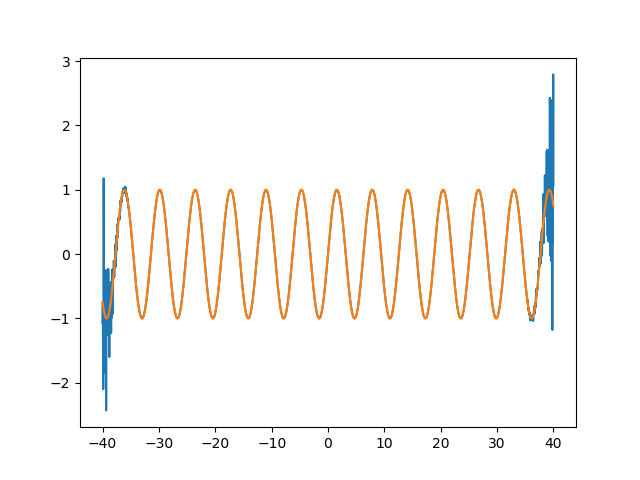

In [3]:
%matplotlib notebook
from pylab import plot, grid, xlim, ylim, sin, linspace

x = linspace(-40, 40, 2000) # choose some appropriate values here
y_series = sine_sum(x)
y_library = sin(x)

plot(x, y_series, x, y_library) # The plot command can take as many x, y pairs as you like.
                                # Note that we do need to repeat x here since this array represents
                                # the x values of two different lines on the plot.
        
# you might like to set the x and y limits using the xlim and ylim functions, or to apply a grid.
# e.g., ylim(-2, 2) will set the y range to run from -2 to 2.

When does your function start to diverge noticeably from the library one? Can you explain why it eventually stops behaving as well as the library function? Can you think of a way to fix this problem? (*Hint*: consider the periodicity of the $\sin$ function.)

▶ **CHECKPOINT 3**